# Phase II: Data Curation, Exploratory Analysis and Plotting (5\%)

### Team Members:
- Siddharth Patel
- Dylan Kim
- Weijie Guan
- Annie Yu

## Part 1:
(1%) Expresses the central motivation of the project and explains the (at least) two key questions to be explored. Gives a summary of the data processing pipeline so a technical expert can easily follow along.


## Problem Motivation
The cryptocurrency market has expanded rapidly over the past decade. Such factors that contributed to this are extreme price volatility and fluctuating investor sentiment. We aim to analyze which factors most strongly influence crypto price movements. Also, we aim to explore whether volatility can be predicted using fundamental metrics like market capitalization, trading volume, and supply.

By studying data from a wide range of coins, we want to answer two questions:
1. Are larger and established coins (like BTC and ETH) less volatile compared to that of smaller or emerging coins?
2. What statistical signals explain short term volatility and how can we use these driven insights to predict how liquidity and market size relate to risk?

Citations:

https://coinmarketcap.com/

https://onlinelibrary.wiley.com/doi/10.1002/ijfe.2778



# Summary of the Data Processing Pipeline

- fetch data from CoinMarketCap API
- clean the data to prepare the dataframe for visualization and analysis
- visualize using plotting library (Matplotlib)



We will first use the CoinMarketCap API to collect the data. This involves adding all the coins into an empty list, then creating a dataframe with it. Next, to process the data, we will begin cleaning it by removing stablecoins, which have an artifically low volatility. Next we will remove all rows with NaNs. In addition, we will add new key features such as volatility and volume to market cap ratio by calculating them with the existing data. These key features will be crucial in answering our questions. We will also create market cap catagories, then organize the coins into them. Finally, we will save the cleaned dataset as a .csv file.

## Part 2:
(2\%) Obtains, cleans, and merges all data sources involved in the project.

In [ ]:
# Importing Necessary Libraries
import requests
import pandas as pd
import numpy as np
from google.colab import userdata

In [ ]:
def collect_crypto_data():
    """
    Fetches data on the top 200 cryptocurrencies by market capitalization
    from the CoinMarketCap API.

    Returns:
        pd.DataFrame: DataFrame containing cryptocurrency metrics
    """

    # HERE YOU WILL HAVE TO GENERATE AN API KEY FROM https://coinmarketcap.com/api/

    url = "https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/latest"
    headers = {"X-CMC_PRO_API_KEY": userdata.get("CRYPTO_API")}
    params = {
        "start": 1,
        "limit": 200,
        "convert": "USD"
    }

    response = requests.get(url, headers=headers, params=params)
    data = response.json()["data"]

    records = []
    for coin in data:
        quote = coin["quote"]["USD"]
        records.append({
            "name": coin["name"],
            "symbol": coin["symbol"],
            "rank": coin["cmc_rank"],
            "market_cap": quote["market_cap"],
            "price": quote["price"],
            "volume_24h": quote["volume_24h"],
            "percent_change_24h": quote["percent_change_24h"],
            "circulating_supply": coin.get("circulating_supply", np.nan)
        })

    return pd.DataFrame(records)

In [ ]:
def clean_crypto_data(crypto_df):
  """
  Cleans given crypto dataframe to remove any stable coins and any NaNs

  Args:
  - crypto_df :: List -> a cleaned version of the crypto_df

  """
  stable_coins = ['USDT', 'USDC', 'BUSD', 'DAI', 'TUSD']
  crypto_df = crypto_df[~crypto_df['symbol'].isin(stable_coins)]

  crypto_df = crypto_df.dropna(subset=['market_cap', 'price', 'volume_24h', 'percent_change_24h'])

  crypto_df['volatility'] = abs(crypto_df['percent_change_24h'])
  crypto_df['volume_to_mcap_ratio'] = crypto_df['volume_24h'] / crypto_df['market_cap']

  crypto_df['cap_category'] = pd.cut(
      crypto_df['market_cap'],
      bins=[0, 1e9, 10e9, 100e9, np.inf],
      labels=['Small', 'Medium', 'Large', 'Mega']
  )

  return crypto_df

In [ ]:
crypto_df = collect_crypto_data()

cleaned_df = clean_crypto_data(crypto_df)

cleaned_df.to_csv("crypto_cleaned.csv", index=False)

print(cleaned_df.head())
print(f"\nDataset shape: {crypto_df.shape}")


       name symbol  rank    market_cap          price    volume_24h  \
0   Bitcoin    BTC     1  2.227144e+12  111693.244287  2.698098e+10   
1  Ethereum    ETH     2  4.782503e+11    3962.362753  1.518473e+10   
3       XRP    XRP     4  1.572487e+11       2.620057  3.941539e+09   
4       BNB    BNB     5  1.551535e+11    1114.770320  2.305617e+09   
5    Solana    SOL     6  1.066220e+11     194.050283  3.325281e+09   

   percent_change_24h  circulating_supply  volatility  volume_to_mcap_ratio  \
0            1.008372        1.993983e+07    1.008372              0.012115   
1            1.329040        1.206983e+08    1.329040              0.031751   
3            5.825413        6.001728e+10    5.825413              0.025066   
4            0.614897        1.391798e+08    0.614897              0.014860   
5            1.422965        5.494555e+08    1.422965              0.031188   

  cap_category  
0         Mega  
1         Mega  
3         Mega  
4         Mega  
5         Meg

## Part 3:
(2\%) Builds at least two visualizations (graphs/plots) from the data which help to understand or answer the questions of interest. These visualizations will be graded based on how much information they can effectively communicate to readers. Please make sure your visualization are sufficiently distinct from each other.

In [ ]:
# Importing plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

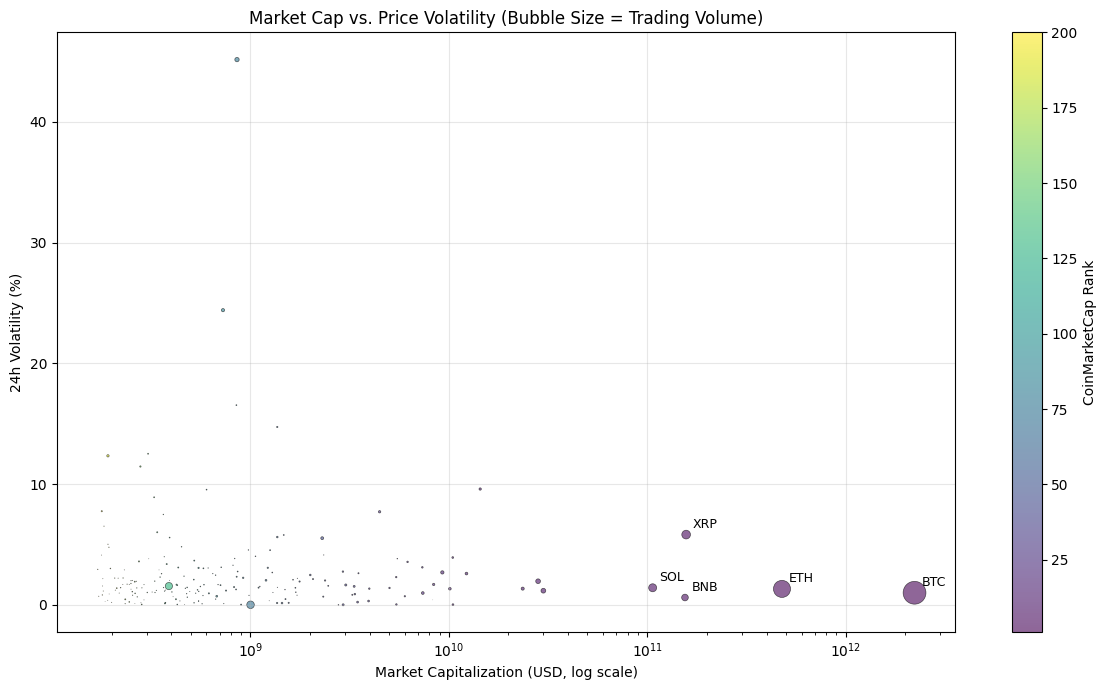

In [ ]:
# Visualization 1: Market Cap vs. Volatility Scatter Plot

plt.figure(figsize=(12, 7))

scatter = plt.scatter(
    cleaned_df['market_cap'],
    cleaned_df['volatility'],
    s=cleaned_df['volume_24h'] / 1e8,
    c=cleaned_df['rank'],
    cmap='viridis',
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5
)

plt.xscale('log')
plt.xlabel('Market Capitalization (USD, log scale)')
plt.ylabel('24h Volatility (%)')
plt.title('Market Cap vs. Price Volatility (Bubble Size = Trading Volume)')

cbar = plt.colorbar(scatter)
cbar.set_label('CoinMarketCap Rank')

# Annotate top 5 coins
for idx, row in cleaned_df.nsmallest(5, 'rank').iterrows():
    plt.annotate(
        row['symbol'],
        (row['market_cap'], row['volatility']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=9
    )

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


This scatter plot explores the relationship between market cap and volatility. Each bubble represents a coin，bigger bubbles mean higher trading volume, and the color shows the coin's rank. We plot market cap against 24-hour volatility to see if larger coins are really more stable. The top 5 coins are labeled so we can see where major players like BTC and ETH sit. This helps us answer whether size actually matters when it comes to price stability

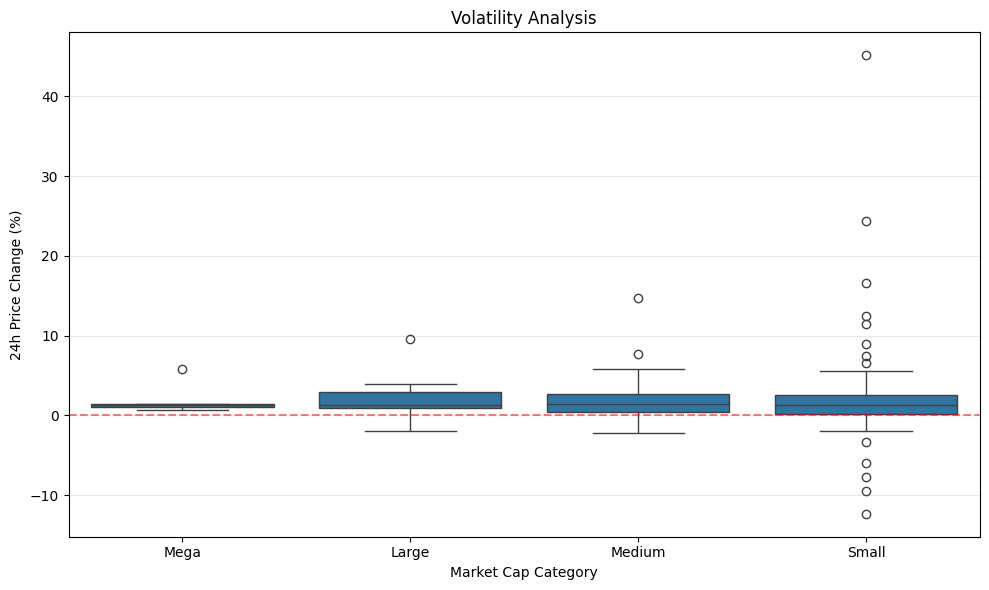

In [ ]:
# Visualization 2: Volatility Distribution by Category (Box Plot)

plt.figure(figsize=(10, 6))

sns.boxplot(
    data=cleaned_df,
    x='cap_category',
    y='percent_change_24h',
    order=['Mega', 'Large', 'Medium', 'Small']
)

plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
plt.xlabel('Market Cap Category')
plt.ylabel('24h Price Change (%)')
plt.title('Volatility Analysis')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

This box plot compares how much prices moved across different market cap categories. We're checking if bigger coins are actually less wild than smaller ones. The boxes show typical price change ranges, dots are individual coins, and the red line marks zero change. By comparing how spread out each category is, we can see if our hypothesis holds, that established coins are more stable than smaller altcoins. Outliers stick out clearly, showing which coins had extreme price swings.